In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Replace 1 with the GPU index you want

import torch
print(torch.cuda.get_device_name(0))  # This will now refer to GPU 1 as "GPU 0" in the notebook context
print(torch.cuda.is_available())

NVIDIA A100-SXM4-80GB
True


In [2]:
import torch
print("Device count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))


Device count: 1
Current GPU: 0
GPU name: NVIDIA A100-SXM4-80GB


In [3]:
import pandas as pd
import json

#Observe final Dataset
df_modbus = pd.read_json("modbus_dataset.jsonl", lines=True)
df_modbus.head()

,query,response
0,060f000000060005fffdff00,060f00000003008502
1,01b7000000060005fffdff00,01b700000003008502
2,05420000000d0010ec88000306831883180000,054200000003009002
3,005f0000000d0010fffd000306ffffffffffff,005f00000003009002
4,05c40000000b00100026000204ffffffff,05c400000006001000260002


In [4]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="RWKV/rwkv-5-world-all-pth",
    filename="RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"
)

print(f"Model downloaded to: {model_path}")


Model downloaded to: /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth


In [4]:
model_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"


In [5]:
import json
print(json.loads('{"mode":"bone","r":32,"load":""}'))


{'mode': 'bone', 'r': 32, 'load': ''}


In [5]:
import wandb
wandb.login()


wandb: Currently logged in as: re2230 (re2230-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [18]:
cd /home/re2230


/home/re2230


/home/re2230/rwkv-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
import subprocess
import shlex
import os

# Activar seguimiento en Weights & Biases
os.environ["WANDB_PROJECT"] = "rwkv-finetune"

from datasets import load_dataset

dataset = load_dataset("json", data_files="modbus_dataset.jsonl")

model_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"

command = f"""
python RWKV-PEFT/train.py \
--load_model {model_path} \
--data_file json \
--data_files /home/re2230/modbus_dataset.jsonl \
--data_type sft \
--sft_field query response \
--ctx_len 512 \
--epoch_steps 50 \
--epoch_count 50 \
--micro_bsz 1 \
--n_layer 24 \
--n_embd 1024 \
--vocab_size 65536 \
--lr_init 6e-5 \
--warmup_steps 10 \
--strategy deepspeed \
--accelerator cuda \
--precision bf16 \
--peft disha \
--disha_config '{{"mode":"bone","r":32,"load":""}}' \
--proj_dir out/rwkv-modbus-ft
"""


result = subprocess.run(shlex.split(command), capture_output=True, text=True)

print("📤 STDOUT:\n", result.stdout)
print("⚠️ STDERR:\n", result.stderr)

if result.returncode != 0:
    print(f"❌ Training failed with exit code {result.returncode}")
else:
    print("✅ Training started successfully")   


📤 STDOUT:
 [2025-06-02 12:30:32,994] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
########## WKV OP           cuda               ##########
########## WKV OP           cuda               ##########
########## WKV OP           cuda               ##########

########## FUSED OP    False          ##########
########## FUSED OP    False          ##########
########## FUSED OP    False          ##########

RWKV_MY_TESTING x052
ninja: no work to do.
RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
        

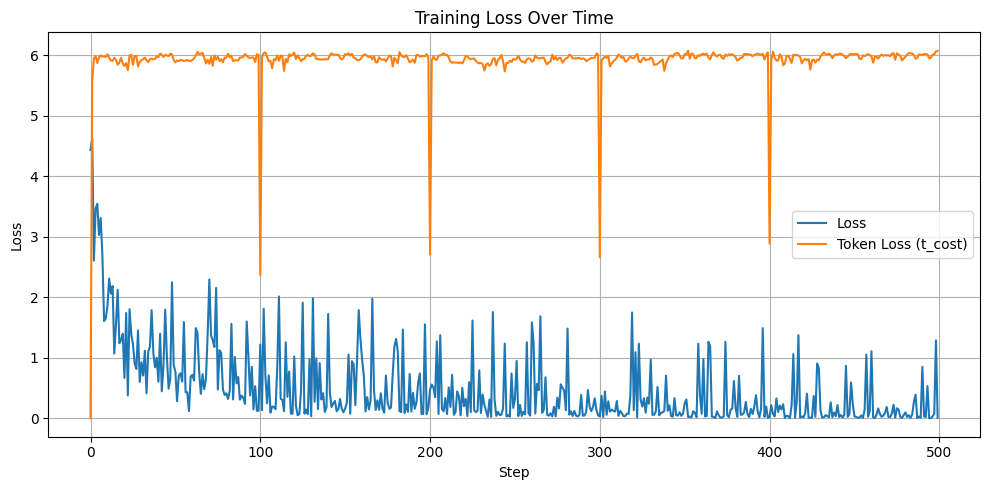

In [20]:
import json
import matplotlib.pyplot as plt

# "loss" – general loss (probably for display)
# "t_cost" – training loss per step (token-level)
# "kt_s" – possibly token-level speed or time per step (not performance-related)

# Load data
with open("out/loss_data.json") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Extract loss values
steps = list(range(len(data)))
loss = [entry["loss"] for entry in data]
t_cost = [entry["t_cost"] for entry in data]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, loss, label="Loss")
plt.plot(steps, t_cost, label="Token Loss (t_cost)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import sys
import os


In [22]:
# Entorno necesarias para RWKV-PEFT
os.environ["RWKV_HEAD_SIZE_A"] = "64"
os.environ["RWKV_MY_TESTING"] = "x052"
os.environ["RWKV_MY_TESTING"] = "x052"
os.environ["RWKV_TRAIN_TYPE"] = "sft"
os.environ["WKV"] = "cuda"
os.environ["FUSED_KERNEL"] = "1"



In [23]:
sys.path.append("/home/re2230/RWKV-PEFT")

In [13]:
import torch

ckpt = torch.load(
    "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    map_location="cpu"
)

print("Number of layers:", len([k for k in ckpt if "blocks." in k and ".att." in k and ".ln_x.weight" in k]))
print("Embedding size (n_embd):", ckpt["blocks.0.att.ln_x.weight"].shape[0])


Number of layers: 24
Embedding size (n_embd): 1024


In [14]:
import torch

ckpt_path = "/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

# Look for an attention-related key to infer context length
for k in ckpt:
    if "time_decay" in k:
        print(k, ckpt[k].shape)
        break


blocks.0.att.time_decay torch.Size([16, 64])


In [28]:
# import torch
# from types import SimpleNamespace  # 🔄 Replacement for InferenceArgs
# from datasets import load_dataset
# from transformers import AutoTokenizer
# from rwkvt.peft.peft_loading import load_peft_model

# args = SimpleNamespace(
#     # Required paths
#     load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
#     adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",

#     # RWKV core
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     dtype="bf16",

#     # PEFT-specific
#     peft="disha",
#     disha_config={"mode": "bone", "r": 32, "load": ""},
#     train_parts="",
#     my_pile_stage=0,

#     # Required flags (even if unused)
#     quant="none",
#     lora_config=None,
#     pissa_config=None,

#     #Required model hyperparameters
#     vocab_size=65536,
#     n_layer=24,
#     n_embd=1024,
#     ctx_len=4096,
#     dim_att=1024,
#     # n_layer=24,
#     # n_embd=1024,
#     # dim_att=768,
#     dim_ffn=3584,
#     head_size_a=64,
#     head_size_divisor=8 
# )


# args, model = load_peft_model(args)
# print(type(model))

# model = model.to(dtype=torch.bfloat16, device="cuda").eval()

# tokenizer = AutoTokenizer.from_pretrained(
#     "RWKV/rwkv-5-world-3b",
#     trust_remote_code=True
# )

# # Step 2: Define Prompt Format

# PROMPT = (
#     "Below is an instruction that describes a task. "
#     "Write a response that appropriately completes the request.\n\n"
#     "### Instruction:\n{instruction}\n\n### Response:"
# )

# def generate_response(instruction, model, tokenizer, args, max_new_tokens=100):
#     prompt = PROMPT.format(instruction=instruction)
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)

#     with torch.no_grad():
#         for _ in range(max_new_tokens):
#             logits = model(input_ids)[0][:, -1, :]
#             next_token = torch.argmax(logits, dim=-1).unsqueeze(0)
#             input_ids = torch.cat([input_ids, next_token], dim=1)
#             if next_token.item() == tokenizer.eos_token_id:
#                 break

#     return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# # Step 3: Load Dataset

# dataset = load_dataset("cerebras/SlimPajama-627B", split="train[:50]")  # Take a small sample

# # Step 4: Create Instructions from Text

# import random
# import jsonlines

# templates = [
#     "Summarize the following:\n\n{text}",
#     "What is this passage about?\n\n{text}",
#     "Rephrase the following in simpler terms:\n\n{text}",
#     "Explain this as if I were a beginner:\n\n{text}",
#     "Identify the key points in this text:\n\n{text}"
# ]

# results = []
# max_input_chars = 1000

# for item in dataset:
#     text = item.get("text", "").strip()
#     if not text or len(text) < 100:
#         continue
#     text = text[:max_input_chars]  # Truncate long examples

#     instruction = random.choice(templates).format(text=text)
#     output = generate_response(instruction, model, tokenizer, args)
    
#     results.append({
#         "instruction": instruction,
#         "generated": output.strip()
#     })


# # Step 5: Save Outputs
# with jsonlines.open("rwkv_slimpajama_outputs.jsonl", mode='w') as writer:
#     for r in results:
#         writer.write(r)

# print("✅ Inference complete. Results saved to 'rwkv_slimpajama_outputs.jsonl'")


In [24]:
import torch
from types import SimpleNamespace  # 🔄 Replacement for InferenceArgs
from datasets import load_dataset
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
import random
import jsonlines
from tqdm import tqdm

args = SimpleNamespace(
    # Required paths
    load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",

    # RWKV core
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="bf16",
    grad_cp=0,  # No gradient checkpointing during inference


    # PEFT-specific
    peft="disha",
    disha_config={"mode": "bone", "r": 32, "load": ""},
    train_parts="",
    my_pile_stage=0,

    # Required flags (even if unused)
    quant="none",
    lora_config=None,
    pissa_config=None,

    # ✅ Required model hyperparameters
    vocab_size=65536,
    n_layer=24,
    n_embd=1024,
    ctx_len=4096,
    dim_att=1024,
    # n_layer=24,
    # n_embd=1024,
    # dim_att=768,
    dim_ffn=3584,
    head_size_a=64,
    head_size_divisor=8 
)


# model = load_peft_model(args)
args, model = load_peft_model(args)
print(type(model))

model = model.to(dtype=torch.bfloat16, device="cuda").eval()

tokenizer = AutoTokenizer.from_pretrained(
    "RWKV/rwkv-5-world-3b",
    trust_remote_code=True
)

# Step 2: Define Prompt Format

PROMPT = "{instruction}"

def generate_response(instruction, model, tokenizer, args, max_new_tokens=100):
    prompt = PROMPT.format(instruction=instruction)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)
            logits = out[0] if isinstance(out, tuple) else out
            next_token = torch.argmax(logits[:, -1], dim=-1).unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)



# Step 3: Load Dataset

dataset = load_dataset("json", data_files="/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl")["train"]

# Limit to first N examples (e.g., 100)
max_examples = 20
dataset = dataset.select(range(min(len(dataset), max_examples)))


results = []

# Procesamiento por ejemplo
for item in tqdm(dataset):
    query = item["query"].strip()
    if not query:
        continue

    output = generate_response(query, model, tokenizer, args)

    results.append({
        "query": query,
        "expected_response": item["response"],
        "generated_response": output.strip()
    })


# Guarda las predicciones
with jsonlines.open("rwkv_modbus_outputs.jsonl", mode='w') as writer:
    for r in results:
        writer.write(r)

print("✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'")


[2025-06-02 12:32:17,419] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
RWKV_MY_TESTING x052


/home/re2230/rwkv-env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/re2230/rwkv-env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


Using /home/re2230/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/re2230/.cache/torch_extensions/py310_cu126/wkv5/build.ninja...
/home/re2230/rwkv-env/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module wkv5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module wkv5...


ninja: no work to do.


Current Python version 3.10 is below the recommended 3.11 version. It is recommended to upgrade to Python 3.11 or higher for the best experience.
########## Loading /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth... ##########


RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
          (output): BoneLinear()
          (gate): BoneLinear()
          (ln_x): GroupNorm(16, 1024, eps=1e-05, affine=True)
        )
        (ffn): RWKV_ChannelMix(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): BoneLinear()
          (receptance): BoneLinear()
          (value): BoneLinear()
        )
      )
      (1-23): 23 x Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     

  0%|          | 0/20 [00:00<?, ?it/s]

['<s>', '02', '1', 'd', '00', '00', '00', '06', '00', '03', 'fff', 'd', '00', '02']


  5%|▌         | 1/20 [00:03<01:09,  3.64s/it]

['<s>', '01', '2', 'c', '00', '00', '00', '06', '00', '05', 'fff', 'df', 'f', '00']


 10%|█         | 2/20 [00:06<01:02,  3.47s/it]

['<s>', '03', 'eb', '00', '00', '00', '06', '00', '05', '00', '09', '00', '00']


 15%|█▌        | 3/20 [00:10<00:58,  3.41s/it]

['<s>', '04', '5', 'd', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01']


 20%|██        | 4/20 [00:14<00:57,  3.57s/it]

['<s>', '06', '10', '00', '00', '00', '0', 'd', '00', '10', '00', '28', '00', '03', '06', '00', '00', 'ffff', '00', '00']


 25%|██▌       | 5/20 [00:17<00:52,  3.53s/it]

['<s>', '05', '8', 'd', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02']


 30%|███       | 6/20 [00:21<00:49,  3.50s/it]

['<s>', '03', '20', '00', '00', '00', '06', '00', '03', '00', '28', '00', '01']


 35%|███▌      | 7/20 [00:24<00:44,  3.44s/it]

['<s>', '02', '3', 'a', '00', '00', '00', '06', '00', '03', 'fff', 'e', '00', '01']


 40%|████      | 8/20 [00:27<00:40,  3.39s/it]

['<s>', '03', '82', '00', '00', '00', '0', 'd', '00', '10', '00', '25', '00', '03', '06', '00', '00', 'a', '99', '4', 'a', '99', '4']


 45%|████▌     | 9/20 [00:30<00:37,  3.37s/it]

['<s>', '02', '53', '00', '00', '00', '06', '00', '03', '00', '00', '00', '02']


 50%|█████     | 10/20 [00:34<00:33,  3.35s/it]

['<s>', '04', 'd', '20', '00', '00', '00', '60', '00', '50', '02', '8', 'ff', '00']


 55%|█████▌    | 11/20 [00:37<00:30,  3.34s/it]

['<s>', '05', '46', '00', '00', '00', '06', '00', '03', '00', '00', '00', '01']


 60%|██████    | 12/20 [00:40<00:26,  3.35s/it]

['<s>', '02', 'ca', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02']


 65%|██████▌   | 13/20 [00:44<00:23,  3.35s/it]

['<s>', '03', '4', 'f', '00', '00', '00', '06', '00', '01', 'eb', '18', '00', '02']


 70%|███████   | 14/20 [00:47<00:20,  3.35s/it]

['<s>', '00', '56', '00', '00', '00', '06', '00', '03', '00', '25', '00', '02']


 75%|███████▌  | 15/20 [00:51<00:16,  3.39s/it]

['<s>', '05', 'fe', '00', '00', '00', '06', '00', '03', 'cab', '30', '00', '2']


 80%|████████  | 16/20 [00:54<00:13,  3.42s/it]

['<s>', '01', 'a', '20', '00', '00', '00', '60', '00', '30', '01', '20', '00', '2']


 85%|████████▌ | 17/20 [00:58<00:10,  3.41s/it]

['<s>', '05', '66', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01']


 90%|█████████ | 18/20 [01:01<00:06,  3.39s/it]

['<s>', '05', '0', 'c', '00', '00', '00', '0', 'd', '00', '10', 'fff', 'd', '00', '03', '06', 'ffffffff', '83', '18']


 95%|█████████▌| 19/20 [01:04<00:03,  3.44s/it]

['<s>', '04', '47', '00', '00', '00', '06', '00', '01', '00', '28', '00', '02']


100%|██████████| 20/20 [01:08<00:00,  3.41s/it]

✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'


In [26]:
#EVALUATING INFERENCE

import jsonlines

def hex_accuracy(pred, target):
    pred_bytes = [pred[i:i+2] for i in range(0, len(pred), 2)]
    target_bytes = [target[i:i+2] for i in range(0, len(target), 2)]
    if not target_bytes:
        return 0.0
    correct = sum(p == t for p, t in zip(pred_bytes, target_bytes))
    return correct / len(target_bytes)

accuracies = []

with jsonlines.open("rwkv_modbus_outputs.jsonl") as reader:
    for entry in reader:
        acc = hex_accuracy(entry["generated_response"], entry["expected_response"])
        accuracies.append(acc)

print(f"✅ Test Byte Accuracy: {sum(accuracies)/len(accuracies):.2%}")


✅ Test Byte Accuracy: 68.28%


In [ ]:
#Test Byte Accuracy: 68.28%

#INFERENCE WITH TRAIN DATA. 

import torch
from types import SimpleNamespace 
from datasets import load_dataset
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
import random
import jsonlines
from tqdm import tqdm

args = SimpleNamespace(
    # Required paths
    load_model="/home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth",
    adapter_path="/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth",

    # RWKV core
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="bf16",
    grad_cp=0,  # No gradient checkpointing during inference


    # PEFT-specific
    peft="disha",
    disha_config={"mode": "bone", "r": 32, "load": ""},
    train_parts="",
    my_pile_stage=0,

    # Required flags (even if unused)
    quant="none",
    lora_config=None,
    pissa_config=None,

    # ✅ Required model hyperparameters
    vocab_size=65536,
    n_layer=24,
    n_embd=1024,
    ctx_len=4096,
    dim_att=1024,
    # n_layer=24,
    # n_embd=1024,
    # dim_att=768,
    dim_ffn=3584,
    head_size_a=64,
    head_size_divisor=8 
)


# model = load_peft_model(args)
args, model = load_peft_model(args)
print(type(model))

model = model.to(dtype=torch.bfloat16, device="cuda").eval()

tokenizer = AutoTokenizer.from_pretrained(
    "RWKV/rwkv-5-world-3b",
    trust_remote_code=True
)

# Step 2: Define Prompt Format

PROMPT = "{instruction}"

def generate_response(instruction, model, tokenizer, args, max_new_tokens=100):
    prompt = PROMPT.format(instruction=instruction)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(args.device)
    print(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)
            logits = out[0] if isinstance(out, tuple) else out
            next_token = torch.argmax(logits[:, -1], dim=-1).unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)



# Step 3: Load Dataset

dataset = load_dataset("json", data_files="/home/re2230/modbus_dataset.jsonl")["train"]

# Limit to first N examples (e.g., 100)
max_examples = 20
dataset = dataset.select(range(min(len(dataset), max_examples)))


results = []

# Procesamiento por ejemplo
for item in tqdm(dataset):
    query = item["query"].strip()
    if not query:
        continue

    output = generate_response(query, model, tokenizer, args)

    results.append({
        "query": query,
        "expected_response": item["response"],
        "generated_response": output.strip()
    })


# Guarda las predicciones
with jsonlines.open("rwkv_modbus_outputs.jsonl", mode='w') as writer:
    for r in results:
        writer.write(r)

print("✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'")


########## Loading /home/re2230/.cache/huggingface/hub/models--RWKV--rwkv-5-world-all-pth/snapshots/d48d1c54cf32cfdc13fca3c767998a0bf3eef8b6/RWKV-5-World-0.4B-v2-20231113-ctx4096.pth... ##########


RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
          (output): BoneLinear()
          (gate): BoneLinear()
          (ln_x): GroupNorm(16, 1024, eps=1e-05, affine=True)
        )
        (ffn): RWKV_ChannelMix(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): BoneLinear()
          (receptance): BoneLinear()
          (value): BoneLinear()
        )
      )
      (1-23): 23 x Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     

  0%|          | 0/20 [00:00<?, ?it/s]

['<s>', '06', '0', 'f', '00', '00', '00', '06', '00', '05', 'fff', 'df', 'f', '00']


  5%|▌         | 1/20 [00:03<01:02,  3.31s/it]

['<s>', '01', 'b', '70', '00', '00', '00', '60', '00', '5', 'fff', 'df', 'f', '00']


 10%|█         | 2/20 [00:06<00:59,  3.29s/it]

['<s>', '05', '42', '00', '00', '00', '0', 'd', '00', '10', 'ec', '88', '00', '03', '06', '83', '18', '83', '18', '00', '00']


 15%|█▌        | 3/20 [00:09<00:56,  3.30s/it]

['<s>', '00', '5', 'f', '00', '00', '00', '0', 'd', '00', '10', 'fff', 'd', '00', '03', '06', 'ffffffff', 'ffff']


 20%|██        | 4/20 [00:13<00:52,  3.28s/it]

['<s>', '05', 'c', '40', '00', '00', '00', 'b', '00', '10', '00', '26', '00', '02', '04', 'ffffffff']


 25%|██▌       | 5/20 [00:16<00:49,  3.29s/it]

['<s>', '05', 'a', '30', '00', '00', '00', '80', '00', 'f', '00', '1', 'b', '00', '02', '01', '01']


 30%|███       | 6/20 [00:19<00:46,  3.30s/it]

['<s>', '02', '0', 'c', '00', '00', '00', '0', 'd', '00', '10', 'ec', '88', '00', '03', '06', '83', '18', 'ffff', '83', '18']


 35%|███▌      | 7/20 [00:23<00:42,  3.31s/it]

['<s>', '03', 'ef', '00', '00', '00', '06', '00', '03', 'cab', '30', '00', '2']


 40%|████      | 8/20 [00:26<00:39,  3.30s/it]

['<s>', '01', '0', 'e', '00', '00', '00', '08', '00', '0', 'f', '00', '25', '00', '03', '01', '07']


 45%|████▌     | 9/20 [00:29<00:36,  3.29s/it]

['<s>', '02', 'c', '30', '00', '00', '00', 'd', '00', '10', 'fff', 'd', '00', '03', '06', '00', '00', '00', '00', '49', 'ea']


 50%|█████     | 10/20 [00:32<00:32,  3.29s/it]

['<s>', '03', 'cd', '00', '00', '00', '06', '00', '03', '00', '25', '00', '02']


 55%|█████▌    | 11/20 [00:36<00:29,  3.28s/it]

['<s>', '05', 'df', '00', '00', '00', '06', '00', '01', 'fff', 'd', '00', '02']


 60%|██████    | 12/20 [00:39<00:26,  3.27s/it]

['<s>', '01', 'b', '10', '00', '00', '00', '60', '00', '3', 'cab', '30', '00', '2']


 65%|██████▌   | 13/20 [00:42<00:23,  3.33s/it]

['<s>', '06', '3', 'e', '00', '00', '00', '0', 'd', '00', '10', '00', '28', '00', '03', '06', '00', '00', '00', '00', 'b', '66', 'd']


 70%|███████   | 14/20 [00:46<00:20,  3.36s/it]

['<s>', '04', 'd', '70', '00', '00', '00', '60', '00', '30', '00', '00', '00', '2']


 75%|███████▌  | 15/20 [00:49<00:16,  3.35s/it]

['<s>', '04', 'aa', '00', '00', '00', '06', '00', '05', '00', '28', 'ff', '00']


 80%|████████  | 16/20 [00:53<00:13,  3.39s/it]

['<s>', '06', '23', '00', '00', '00', '06', '00', '01', 'fff', 'd', '00', '02']


 85%|████████▌ | 17/20 [00:56<00:10,  3.40s/it]

['<s>', '05', '62', '00', '00', '00', '0', 'd', '00', '10', 'cab', '30', '00', '30', '6', 'b', '66', 'df', 'ffffff', 'f']


 90%|█████████ | 18/20 [00:59<00:06,  3.37s/it]

['<s>', '02', '04', '00', '00', '00', '06', '00', '05', 'fff', 'eff', '00']


 95%|█████████▌| 19/20 [01:03<00:03,  3.33s/it]

['<s>', '03', 'ce', '00', '00', '00', '06', '00', '01', 'fff', 'e', '00', '01']


100%|██████████| 20/20 [01:06<00:00,  3.32s/it]

✅ Inference complete. Results saved to 'rwkv_modbus_outputs.jsonl'


In [ ]:
import time

results = []
total_time = 0
num_queries = 0

for item in tqdm(dataset):
    query = item["query"].strip()
    expected = item["response"].strip()
    if not query:
        continue

    instruction = PROMPT.format(query=query)

    start_time = time.time()
    output = generate_response(instruction, model, tokenizer, args)
    elapsed = time.time() - start_time

    results.append({
        "query": query,
        "expected_response": expected,
        "generated_response": output.strip(),
        "inference_time_sec": elapsed
    })

    total_time += elapsed
    num_queries += 1

avg_time = total_time / num_queries
print(f"✅ Inference complete. Avg time per query: {avg_time:.4f} seconds")


In [ ]:
import os
import json
import torch
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
from rwkvt.args_type import TrainingArgs
from rwkv.utils import PIPELINE

IGNORE_INDEX = -100
EOT_TOKEN = "\x17"
PROMPT = (
    "Below is an instruction that describes a task. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{instruction}")

# Setup model args
args = TrainingArgs()
args.load_model = "/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth"
args.strategy = "cuda bf16"
args.ctx_len = 512
args.peft = "disha"
args.n_layer = 24
args.n_embd = 1024
args.vocab_size = 65536
args.dim_att = 1024
args.dim_ffn = 3584
args.head_size_a = 64
args.head_size_divisor = 8
args.disha_config = {"mode": "bone", "r": 32, "load": ""}


# 🧪 Evaluation loop
args, model = load_peft_model(args)
model = model.to(dtype=torch.bfloat16, device="cuda").eval()

test_file = "/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl"
correct = 0
total = 0

with open(test_file, "r") as f:
    for line in f:
        item = json.loads(line)
        prompt = PROMPT.format_map({"instruction": item["query"]})
        expected = item["response"]

        # # 🔁 Tokenizar
        # input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()


        with torch.no_grad():
            input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to("cuda")  # Mantener como int64

            # El modelo automáticamente opera en bfloat16 si se cargó con strategy="cuda bf16"
            logits = model(input_ids)[0]
            pred_ids = torch.argmax(logits, dim=-1)
            output = tokenizer.decode(pred_ids[0], skip_special_tokens=True)

        # 🎯 Comparación exacta
        if output.strip() == expected.strip():
            correct += 1
        total += 1

print(f"✅ Accuracy (BCA): {correct / total:.4f} ({correct}/{total})")


In [ ]:
import os
import json
import torch
from transformers import AutoTokenizer
from rwkvt.peft.peft_loading import load_peft_model
from rwkvt.args_type import TrainingArgs
from rwkv.utils import PIPELINE

IGNORE_INDEX = -100
EOT_TOKEN = "\x17"
PROMPT = (
    "Below is an instruction that describes a task. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{instruction}\n\n### Response:"
)

# ⚙️ Setup model args
args = TrainingArgs()
args.load_model = "/home/re2230/out/rwkv-modbus-ft/rwkv-4.pth"
args.strategy = "cuda bf16"
args.ctx_len = 512
args.peft = "disha"
args.n_layer = 24
args.n_embd = 1024
args.vocab_size = 65536
args.dim_att = 1024
args.dim_ffn = 3584
args.head_size_a = 64
args.head_size_divisor = 8
args.disha_config = {"mode": "bone", "r": 32, "load": ""}


# 🧪 Evaluation loop
args, model = load_peft_model(args)
model = model.to(dtype=torch.bfloat16, device="cuda").eval()

# model.eval().cuda()

# 🧠 Cargar tokenizer (misma ruta usada en entrenamiento)
tokenizer = AutoTokenizer.from_pretrained("RWKV/rwkv-5-world-3b", trust_remote_code=True)

# 📄 Evaluación con archivo jsonl
PROMPT = (
    "Below is an instruction that describes a task. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{instruction}\n\n### Response:"
)

test_file = "/home/re2230/RWKV-PEFT/rwkvt/dataset/modbus_dataset_test.jsonl"
correct = 0
total = 0

with open(test_file, "r") as f:
    for line in f:
        item = json.loads(line)
        prompt = PROMPT.format_map({"instruction": item["query"]})
        expected = item["response"]

        # 🔁 Tokenizar
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()

        # 🔮 Inferencia
# 🔮 Inferencia
        with torch.no_grad():
            input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to("cuda")  # Mantener como int64

            # El modelo automáticamente opera en bfloat16 si se cargó con strategy="cuda bf16"
            logits = model(input_ids)[0]
            pred_ids = torch.argmax(logits, dim=-1)
            output = tokenizer.decode(pred_ids[0], skip_special_tokens=True)

        # 🎯 Comparación exacta
        if output.strip() == expected.strip():
            correct += 1
        total += 1

print(f"✅ Accuracy (BCA): {correct / total:.4f} ({correct}/{total})")


########## Loading /home/re2230/out/rwkv-modbus-ft/rwkv-4.pth... ##########


RWKV(
  (model): RWKV5(
    (emb): Embedding(65536, 1024)
    (blocks): ModuleList(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (att): RWKV_TimeMix_RWKV5(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): BoneLinear()
          (key): BoneLinear()
          (value): BoneLinear()
          (output): BoneLinear()
          (gate): BoneLinear()
          (ln_x): GroupNorm(16, 1024, eps=1e-05, affine=True)
        )
        (ffn): RWKV_ChannelMix(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): BoneLinear()
          (receptance): BoneLinear()
          (value): BoneLinear()
        )
      )
      (1-23): 23 x Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     